In [4]:
import os
from matplotlib import pyplot
import numpy as np
import numpy.testing as npt
from scipy.spatial.transform import Rotation
import pickle
from PIL import Image
from IPython.display import display
from ipywidgets import interact
from importlib import reload

In [5]:
import trimesh
import pyrender

In [6]:
from face3drotationaugmentation.facemodel.bfm import BFMModel
import face3drotationaugmentation.dataset300wlp as dataset300wlp
import face3drotationaugmentation.vis as vis

In [7]:
reload(vis)

<module 'face3drotationaugmentation.vis' from '/mnt/SSDNTFS/Programmierung/head-tracking/face-3d-rotation-augmentation/face3drotationaugmentation/vis.py'>

In [8]:
ds300wlp = dataset300wlp.Dataset300WOriginals(os.path.join(os.environ['DATADIR'],'300W-LP.zip'))

In [9]:
original_sample = ds300wlp[50]

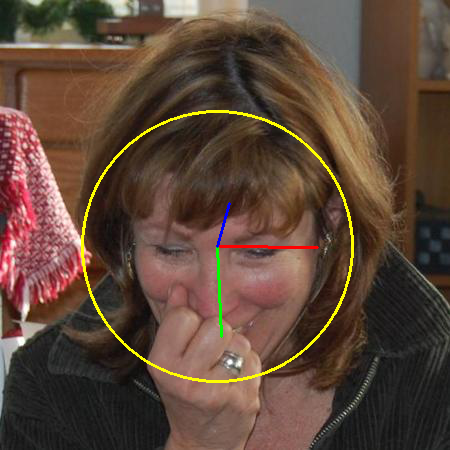

In [10]:
img = original_sample['image'].copy()
vis.draw_pose(img, original_sample, 255, 2)
display(Image.fromarray(img))

In [11]:
#os.environ['PYOPENGL_PLATFORM'a] = 'egl'

In [12]:
def get_hpb(rot : Rotation):
    '''Conversion to heading-pitch-bank.
    
    First rotation is around z (bank/roll), then x (pitch), then y (yaw/heading)
    '''
    return rot.as_euler('YXZ')


def make_rot_by_axis_rotations(hpb):
    '''For testing - to ensure we have the right convention.'''
    h, p, b = hpb.T
    z = np.zeros(h.shape)
    return Rotation.from_rotvec(np.vstack([z,h,z]).T) * Rotation.from_rotvec(np.vstack([p,z,z]).T) * Rotation.from_rotvec(np.vstack([z,z,b]).T)


def make_rot(hpb):
    '''Conversion from heading-pitch-bank.
    
    First rotation is around z (bank/roll), then x (pitch), then y (yaw/heading)
    '''
    return Rotation.from_euler('YXZ', hpb)


def test_euler_angle_functions():
    ref_rots = Rotation.random(num=1000)
    hpb = get_hpb(ref_rots)
    rots = make_rot(hpb)
    npt.assert_array_less((rots.inv() * ref_rots).magnitude(), 1.e-6)
    npt.assert_array_less((rots.inv() * make_rot_by_axis_rotations(hpb)).magnitude(), 1.e-6)

    
test_euler_angle_functions()

In [13]:
def load_base_mesh(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        tris = np.asarray(data['tris'])
        base_vertices = np.asarray(data['vertices'])
        base_vertices *= 0.01  # Vertices were changed during import in 3d software
        base_vertices[:,1] *= -1 # Vertices were changed during import in 3d software
        blend_weights = np.asarray(data['weights'])
        # Dummy is good enough for unlit scene
        normals = np.broadcast_to(np.asarray([[ 0., 0., 1.]]), (len(base_vertices),3))
        return base_vertices, tris, blend_weights, normals

In [14]:
%matplotlib inline

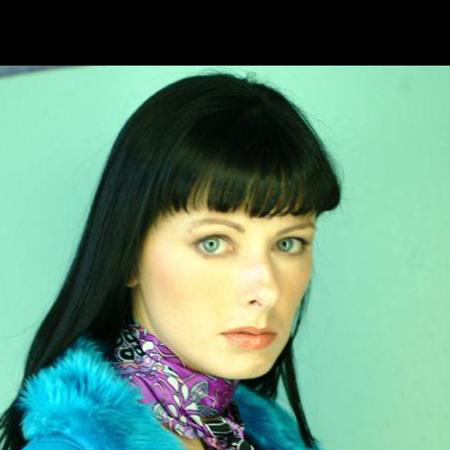

In [15]:
sample = ds300wlp[19]
display(Image.fromarray(sample['image']))

In [16]:
xy = sample['xy']
scale = sample['scale']
shapeparam = sample['shapeparam']
image = sample['image']
rot = sample['rot']

In [17]:
h, w, _ = image.shape
renderer = pyrender.OffscreenRenderer(viewport_width=w, viewport_height=h)

In [18]:
base_mesh = load_base_mesh("face3drotationaugmentation/full_bfm_mesh_with_bg.pkl")
bfm = BFMModel(40, 10)


def _compute_posed_vertices(base_vertices, vertices, xy, scale, rot, blend_weights, additional_rot=None, rotation_center=None):
    if additional_rot is not None and rotation_center is not None:
        vertices = additional_rot.apply(vertices - rotation_center[None,:]) + rotation_center[None,:]
    vertices = rot.apply(vertices)
    vertices = vertices * blend_weights[:,None] + (1.-blend_weights[:,None]) * base_vertices
    vertices *= scale
    vertices[:,:2] += xy
    return vertices


class FaceWithBackgroundModel(object):
    def __init__(self, base_mesh, bfm, xy, scale, rot, shapeparam, image):
        self._base_vertices, self._tris, self._blend_weights, self._normals = base_mesh
        self._bfm = bfm
        self._rot = rot
        self._xy = xy
        self._scale = scale
        
        self._unposed_vertices = self._base_vertices.copy()
        self._unposed_vertices[:bfm.vertexcount,:] += np.sum(bfm.scaled_bases * shapeparam[:,None,None], axis=0)

        self.background_plane_z_coord = scale*np.average(self._unposed_vertices[self._blend_weights < 0.01,2])

        h, w = image.shape[:2]
        
        # Extra border to generate black pixels outside of the original image region.
        # Because the the deformation will pull parts of the mesh into the view which
        # were not part of the original image.
        texture_border = 50 # pixels
        
        vertices_for_uv = _compute_posed_vertices(self._base_vertices, self._unposed_vertices, xy, scale, rot, self._blend_weights)
        # By default, without texture border, the range from [0,w] is mapped to [0,1]
        # With border ...
        #    Range from -border to w+border is mapped to [0,1]
        uvs = (vertices_for_uv[:,:2] + texture_border) / (np.asarray([[w, h]]) + 2*texture_border)
        uvs[:,1] = 1. - uvs[:,1]
        self._uvs = uvs
    
        # Dummy data is good enough for unlit scene
        self._normals = np.broadcast_to(np.asarray([[ 0., 0., 1.]]), (len(self._base_vertices),3))
    
        self._rotation_center = np.array([0., 0.33, 0.25])

        tex = np.zeros((h+2*texture_border,w+2*texture_border,4), dtype=np.uint8)
        tex[texture_border:-texture_border, texture_border:-texture_border,:3] = image
        tex[:,:,3] = 255 # Alpha channel

        self._tex = pyrender.Texture(
            source = tex,
            source_channels = 'RGBA', # RGB doesn't work
            data_format = pyrender.texture.GL_UNSIGNED_BYTE,
            sampler = pyrender.Sampler(
                wrapS=pyrender.GLTF.CLAMP_TO_EDGE, 
                wrapT=pyrender.GLTF.CLAMP_TO_EDGE)
        )
    
        self._mat = pyrender.MetallicRoughnessMaterial(baseColorTexture=self._tex, doubleSided=True)

    def __call__(self, rotation_offset):
        vertices = _compute_posed_vertices(self._base_vertices, self._unposed_vertices, self._xy, self._scale, self._rot, self._blend_weights, rotation_offset, self._rotation_center)
        prim = pyrender.Primitive(positions = vertices, indices=self._tris, texcoord_0 = self._uvs, normals=self._normals, material=self._mat)
        return pyrender.Mesh(primitives = [prim])

In [19]:
def add_camera(scene, image_shape, background_plane_z_coord):
    h, w, _ = image_shape
    zdistance = 10000
    fov = 2.*np.arctan(0.5*(h)/(zdistance + background_plane_z_coord))
    cam = pyrender.PerspectiveCamera(yfov=fov, znear = zdistance-scale*2, zfar = zdistance+scale*2)
    campose = np.eye(4)
    campose[:3,3] = [ w//2, h//2, -zdistance  ]
    campose[:3,:3] = [
        [ 1, 0, 0 ],
        [ 0, 0, -1 ],
        [ 0, -1, 0 ]
    ]
    scene.add(cam, pose=campose)

In [20]:
face_model = FaceWithBackgroundModel(base_mesh, bfm, xy, scale, rot, shapeparam, image)

In [21]:
scene = pyrender.Scene(ambient_light=[1., 1., 1.], bg_color=[0.0, 0.0, 0.0])

add_camera(scene, image.shape, face_model.background_plane_z_coord)

In [22]:
@interact(yaw = (-1.5, 1.5), pitch = (-1., 1.))
def showit(yaw, pitch):
    more_rot = Rotation.from_rotvec([0., yaw, 0.]) * Rotation.from_rotvec([ pitch, 0., 0.])
    
    face_node = scene.add(face_model(more_rot))

    color, depth = renderer.render(scene)

    scene.remove_node(face_node)

    display(Image.fromarray(color))

interactive(children=(FloatSlider(value=0.0, description='yaw', max=1.5, min=-1.5), FloatSlider(value=0.0, des…

In [23]:
# class FaceAugmentationRenderer(object):
#     def __init__(self, )